In [1]:
# imports
import torch
import ray
import os
import shutil
import matplotlib.pyplot as plt
import seaborn as sns

from DataObjects.DataLoader import DataLoader
from Architectures.Transformer.GPT2 import GPT2FineTuner
from ray import tune
from ray.tune.schedulers import ASHAScheduler
from ray.air import session

from pathlib import Path
import numpy as np

/home/piotr/PycharmProjects/dl_project1/DeepLearning/Project_II/.venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-04-27 12:57:05,078	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-04-27 12:57:06,346	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [2]:
# SETTING SEED
SEED = 42069    
torch.manual_seed(SEED)
np.random.seed(0)

In [3]:
# set device to cuda
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [ ]:
def train_gpt2(config, audio_dim, num_labels, device):
    # Initialize GPT2 model with parameters from Ray Tune's search space
    model = GPT2FineTuner(
        audio_dim=audio_dim,
        num_labels=num_labels,
        pretrained=True,
        model_name="gpt2",
        lr=config["lr"],  # Hyperparameter from Ray Tune
    ).to(device)

    train_loader = DataLoader(
    data_dir=config["train_dir"],
    data_type='mfcc',
    batch_size=config["batch_size"],
    shuffle=True
    )
    val_loader = DataLoader(
    data_dir=config["val_dir"],
    data_type='mfcc',
    batch_size=config["batch_size"],
    shuffle=True
    )

    # Training loop
    model.train_architecture(train_loader=train_loader, val_loader=val_loader, epochs=config["epochs"])

    # Evaluate the model
    results = model.evaluate(val_loader)

    final_loss = results["summary"]["loss"]
    final_acc = results["summary"]["accuracy"]

    # Report the validation accuracy or other metrics as the result
    if not session.get_session():
        return final_loss, final_acc
    return None

In [ ]:
@ray.remote
def setup_worker():
    """Ensure each Ray worker has access to the dataset."""
    worker_data_path = os.path.join(os.getcwd(), "worker_data")

    if not os.path.exists(worker_data_path):
        os.makedirs(worker_data_path)

    # Copy dataset if it doesn’t already exist
    source_data_path = os.path.abspath("Data/MFCC_transformed")
    if not os.path.exists(os.path.join(worker_data_path, "MFCC_transformed")):
        shutil.copytree(source_data_path, os.path.join(worker_data_path, "MFCC_transformed"))

    return f"Worker setup complete: {worker_data_path}"

In [ ]:
config = {
    "lr": tune.loguniform(1e-5, 1e-3),  # Learning rate search space
    "epochs": tune.choice([1, 3, 5, 7]), # Number of epochs to train
    "batch_size": tune.choice([4, 16, 32, 64]), # Batch size choice
    "train_dir": os.path.abspath("Data/MFCC_transformed/training"),
    "val_dir":  os.path.abspath("Data/MFCC_transformed/validation")
}

In [ ]:
# Set up a scheduler for early stopping based on validation accuracy
scheduler = ASHAScheduler(
    metric="accuracy",  # Objective metric
    mode="max",         # We want to maximize accuracy
    max_t=10,           # Maximum number of epochs to run
    grace_period=2,     # Number of epochs to wait before evaluating
    reduction_factor=2  # Reduce the number of trials as we progress
)

In [4]:
DATA_PATH = Path("Data")

In [5]:
# prepare Data Loader files
train_dir = DATA_PATH / Path("MFCC_transformed", "training")
val_dir = DATA_PATH / Path("MFCC_transformed", "validation")
test_dir = DATA_PATH / Path("MFCC_transformed", "testing")

batch_size = 64

train_loader = DataLoader(
    data_dir=train_dir,
    data_type='mfcc',
    batch_size=batch_size,
    shuffle=True
)
val_loader = DataLoader(
    data_dir=val_dir,
    data_type='mfcc',
    batch_size=batch_size,
    shuffle=True
)

test_loader = DataLoader(
    data_dir=test_dir,
    data_type='mfcc',
    batch_size=batch_size,
    shuffle=True
)

# Inspect class mapping and dataset size
print("Classes:", train_loader.class_to_idx)
print("# training batches:", len(train_loader))

print("# validation batches:", len(val_loader))

print("# testing batches:", len(test_loader))

Classes: {'bed': 0, 'bird': 1, 'cat': 2, 'dog': 3, 'down': 4, 'eight': 5, 'five': 6, 'four': 7, 'go': 8, 'happy': 9, 'house': 10, 'left': 11, 'marvin': 12, 'nine': 13, 'no': 14, 'off': 15, 'on': 16, 'one': 17, 'right': 18, 'seven': 19, 'sheila': 20, 'silence': 21, 'six': 22, 'stop': 23, 'three': 24, 'tree': 25, 'two': 26, 'up': 27, 'wow': 28, 'yes': 29, 'zero': 30}
# training batches: 797
# validation batches: 108
# testing batches: 108


In [6]:
batch = next(iter(train_loader))
C, *rest = batch.data.shape[1:] 
audio_dim = C                     

num_labels = len(train_loader.class_to_idx)

In [ ]:
ray.init(ignore_reinit_error=True)
ray.get(setup_worker.remote())

trainable = tune.with_parameters(train_gpt2, audio_dim=audio_dim, num_labels=num_labels, device=device)

trainable = tune.with_resources(trainable, resources={"cpu": 16, "gpu": 1})

tuner = tune.Tuner(
    trainable,
    param_space=config,
    tune_config=tune.TuneConfig(
        scheduler=scheduler,
        num_samples=20,
    ),
)

results = tuner.fit()

best_result = results.get_best_result(metric="accuracy", mode="max")
best_config = best_result.config
print("Best config: ", best_config)

Best config:  {'lr': 0.00020677929251336613, 'epochs': 5, 'batch_size': 64

In [ ]:
loss_tab = []
acc_tab = []
lr_tab = []
batch_size_tab = [4, 16, 32, 64]
epoch_tab = [1, 3, 5, 7]

In [ ]:
lr_tab.clear()
loss_tab.clear()
acc_tab.clear()
for i in np.arange(0.6, 1.51, 0.1):
    config_lr = best_config.copy()
    config_lr["lr"] = best_config.get("lr")*i
    lr_tab.append(config_lr["lr"])

    [loss, acc] = train_gpt2(config_lr, audio_dim, num_labels, device)
    loss_tab.append(loss)
    acc_tab.append(acc)

In [ ]:
# Plot loss and accuracy vs learning rate
plt.figure(figsize=(10, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(lr_tab, loss_tab, marker='o', linestyle='-')
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.title("Loss vs Learning Rate")

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(lr_tab, acc_tab, marker='o', linestyle='-', color='g')
plt.xlabel("Learning Rate")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Learning Rate")

plt.tight_layout()
plt.show()

In [ ]:
loss_tab.clear()
acc_tab.clear()
for i in batch_size_tab:
    config_batch = best_config.copy()
    config_batch["batch_size"] = i

    [loss, acc] = train_gpt2(config_batch, audio_dim, num_labels, device)
    loss_tab.append(loss)
    acc_tab.append(acc)

In [ ]:
# Plot loss and accuracy vs learning rate
plt.figure(figsize=(10, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(batch_size_tab, loss_tab, marker='o', linestyle='-')
plt.xlabel("Batch Size")
plt.ylabel("Loss")
plt.title("Loss vs Batch Size")

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(batch_size_tab, acc_tab, marker='o', linestyle='-', color='g')
plt.xlabel("Batch Size")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Batch Size")

plt.tight_layout()
plt.show()

In [ ]:
loss_tab.clear()
acc_tab.clear()
for i in epoch_tab:
    config_epoch = best_config.copy()
    config_epoch["epochs"] = i

    [loss, acc] = train_gpt2(config_epoch, audio_dim, num_labels, device)
    loss_tab.append(loss)
    acc_tab.append(acc)

In [ ]:
# Plot loss and accuracy vs learning rate
plt.figure(figsize=(10, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(epoch_tab, loss_tab, marker='o', linestyle='-')
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.title("Loss vs Number of epochs")

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(epoch_tab, acc_tab, marker='o', linestyle='-', color='g')
plt.xlabel("Number of epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Number of epochs")

plt.tight_layout()
plt.show()

# Evaluate optimal setup

In [12]:
model = GPT2FineTuner(
    audio_dim=audio_dim,
    num_labels=num_labels,
    pretrained=True,
    model_name="gpt2",
    lr=0.00020677929251336613
).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

In [13]:
# training loop
# takes long time for gpt2...
model.train_architecture(train_loader = train_loader, epochs = 5)

Epoch 1/5 - train loss: 1.4170 - train acc: 0.5875
Epoch 2/5 - train loss: 0.4225 - train acc: 0.8742
Epoch 3/5 - train loss: 0.3101 - train acc: 0.9086
Epoch 4/5 - train loss: 0.2562 - train acc: 0.9230
Epoch 5/5 - train loss: 0.2188 - train acc: 0.9350


In [14]:
results = model.evaluate(test_loader)
print("Validation Summary:")
for k, v in results['summary'].items():
    print(f"  {k}: {v:.4f}")

Evaluating GPT2: 100%|██████████| 108/108 [00:08<00:00, 12.48it/s]

Validation Summary:
  loss: 0.3332
  accuracy: 0.9069
  precision: 0.9102
  recall: 0.9090
  f1: 0.9077


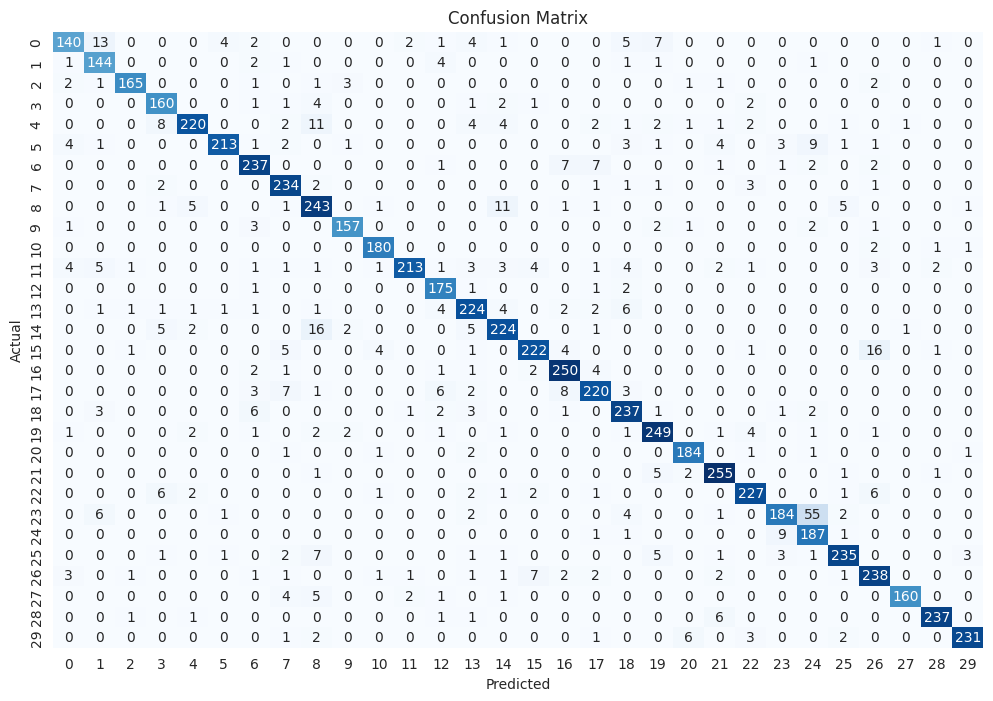

In [15]:
cm = results['confusion_matrix']
# Plotting
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

## More automated approach to running tests
Running tests throgh an automated Experiment Object created through ExperimentFactory for easy and streamlined experiments.

In [ ]:
from DataObjects.Experiments import ExperimentFactory, GPT2Experiment

In [ ]:
# set device to cuda
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

In [ ]:
gpt2_exp = ExperimentFactory.create_experiment(
    arch_name='gpt2',
    train_dir='Data/MFCC_transformed/training',
    val_dir='Data/MFCC_transformed/validation',
    test_dir='Data/MFCC_transformed/testing',
    batch_size=32,
    epochs=5,
    audio_dim=128,
    save_path = "Saved_experimented_data/GPT2_experiment.txt",     
    model_kwargs={
        'num_labels': 31,
        'pretrained': False,
        'model_name': 'gpt2',
        'lr': 5e-5
    }
)

In [ ]:
gpt2_exp.run()